#### Births Modeler: &nbsp; Using Decision Trees and Random Forests

+ births clasification via decision trees and random forests...
+ You're classifying "above" (above-median popularity of birthdays) vs "below" (below-median popularity of birthdays)
+ Feel free to re-use the cleaned data from previous weeks (already here)
+ Suggestion:  &nbsp; go cell-by-cell using the iris_modeler example, copying-and-adapting as you go...

In [ ]:
#
# hw6pr1births_modeler:  bday popularity modeling by month + day    
#                                                 (above/below median: 190942)
#

#
# SUGGESTION:  
# 
# +++ copy-paste-and-alter from the week6 iris-modeling notebook into here +++
#

## Data set up...
+ Use the cleaned data from prior weeks (it should be here in this folder as births_cleaned.csv)
+ Be sure to get rid of the column with the **number of births** &nbsp;&nbsp; That makes the prediction "too easy"!
+ Instead, see how well the DT/RF techniques can predict above/below-median popularity, just based on month and day...
+ (It's quite a hard estimation problem!)

In [1]:
# libraries!
import numpy as np      # numpy is Python's "array" library
import pandas as pd     # Pandas is Python's "data" library ("dataframe" == spreadsheet)

In [2]:
# let's read in our births data...
# 
# births_cleaned.csv should be in this folder
# 
filename = 'births_cleaned.csv'
df_tidy = pd.read_csv(filename)      # encoding = "utf-8", "latin1"
print(f"{filename} : file read into a pandas dataframe.")

births_cleaned.csv : file read into a pandas dataframe.


In [3]:
#
# different version vary on how to see all rows (adapt to suit your system!)
#
print(f"df_tidy.shape is {df_tidy.shape}\n")

df_tidy.shape is (366, 4)



In [4]:
df_tidy.info()  # prints column information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   month               366 non-null    int64 
 1   day                 366 non-null    int64 
 2   births              366 non-null    int64 
 3   above/below median  366 non-null    object
dtypes: int64(3), object(1)
memory usage: 11.6+ KB


In [5]:
df_tidy   # let's see a few rows!

,month,day,births,above/below median
0,2,29,46420,below
1,12,25,153778,below
2,1,1,160369,below
3,12,24,165050,below
4,1,2,169896,below
...,...,...,...,...
361,9,17,211263,above
362,9,24,211362,above
363,9,22,212673,above
364,9,23,212817,above


In [6]:
#
# All of the columns need to be numeric, we'll drop irisname
ROW = 0
COLUMN = 1
df_model1 = df_tidy.drop('births', axis=COLUMN )
df_model1

,month,day,above/below median
0,2,29,below
1,12,25,below
2,1,1,below
3,12,24,below
4,1,2,below
...,...,...,...
361,9,17,above
362,9,24,above
363,9,22,above
364,9,23,above


In [32]:
#
# once we have all the columns we want, let's create an index of their names...

#
# Let's make sure we have all of our helpful variables in one place 
#       To be adapted if we drop/add more columns...
#

#
# let's keep our column names in variables, for reference
#
COLUMNS = df_model1.columns            # "list" of columns
print(f"COLUMNS is {COLUMNS}\n")  
  # It's a "pandas" list, called an Index
  # use it just as a Python list of strings:
print(f"COLUMNS[0] is {COLUMNS[0]}\n")

# let's create a dictionary to look up any column index by name
COL_INDEX = {}
for i, name in enumerate(COLUMNS):
    COL_INDEX[name] = i  # using the name (as key), look up the value (i)
print(f"COL_INDEX is {COL_INDEX}\n\n")

#
# Feature names!
#
FEATURES = COLUMNS[0:2]

#
# and our "species" names
#

# all of scikit-learn's ML routines need numbers, not strings
#   ... even for categories/classifications (like species!)
#   so, we will convert the flower-species to numbers:

SPECIES = ['below', 'above']   # int to str
SPECIES_INDEX = {'below':0,'above':1}  # str to int

def convert_species(speciesname):
    """ return the species index (a unique integer/category) """
    return SPECIES_INDEX[speciesname]

# Let's try it out...
for name in SPECIES:
    print(f"{name} maps to {SPECIES_INDEX[name]}")

COLUMNS is Index(['month', 'day', 'above/below median'], dtype='object')

COLUMNS[0] is month

COL_INDEX is {'month': 0, 'day': 1, 'above/below median': 2}


below maps to 0
above maps to 1


In [11]:
#
# we can "apply" to a whole column and create a new column
#   it may give a warning, but this is ok...
#

df_model2 = df_model1.copy()  # copy everything AND...

# add a new column, 'irisnum'
df_model2['above/below median'] = df_model2['above/below median'].apply(convert_species)

# let's see...
df_model2

,month,day,above/below median
0,2,29,0
1,12,25,0
2,1,1,0
3,12,24,0
4,1,2,0
...,...,...,...
361,9,17,1
362,9,24,1
363,9,22,1
364,9,23,1


In [13]:
#
# let's convert our dataframe to a numpy array, named A
#
A = df_model2.to_numpy()   
print(A)


[[ 2 29  0]
 [12 25  0]
 [ 1  1  0]
 ...
 [ 9 22  1]
 [ 9 23  1]
 [ 9 16  1]]


In [14]:
#
# let's make sure it's all floating-point (here, it already is, but in other datasets it might not be)
#
A = A.astype('float64')  # so many:  www.tutorialspoint.com/numpy/numpy_data_types.htm
print(A)

[[ 2. 29.  0.]
 [12. 25.  0.]
 [ 1.  1.  0.]
 ...
 [ 9. 22.  1.]
 [ 9. 23.  1.]
 [ 9. 16.  1.]]


In [15]:
#
# nice to have NUM_ROWS and NUM_COLS around
#
NUM_ROWS, NUM_COLS = A.shape
print(f"\nThe dataset has {NUM_ROWS} rows and {NUM_COLS} cols")


The dataset has 366 rows and 3 cols


In [23]:
# let's use all our variables, to reinforce that we have
# (1) their names...
# (2) access and control over each...

# choose a row index, n:
n = 42
print(f"day #{n} corresponds to {A[n]}")

for i in range(len(COLUMNS)):
    colname = COLUMNS[i]
    value = A[n][i]
    print(f"  Its {colname} is {value}")

species_index = COL_INDEX['above/below median']
species_num = int(A[n][species_index])
species = SPECIES[species_num]
print(species_index, species_num)
print(f"  Its species is {species} (i.e., {species_num})")

day #42 corresponds to [1. 8. 0.]
  Its month is 1.0
  Its day is 8.0
  Its above/below median is 0.0
2 0
  Its species is below (i.e., 0)


In [24]:
print("+++ Start of data definitions +++\n")

#
# we could do this at the data-frame level, too!
#

X_all = A[:,0:2]  # X (features) ... is all rows, columns 0, 1
y_all = A[:,2]    # y (labels) ... is all rows, column 2 only

print(f"y_all (just the labels/species)   are \n {y_all}")
print(f"X_all (just the features, first few rows) are \n {X_all[0:5]}")

+++ Start of data definitions +++

y_all (just the labels/species)   are 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [25]:
#
# we scramble the data, to remove (potential) dependence on its ordering: 
# 
indices = np.random.permutation(len(y_all))  # indices is a permutation-list

# we scramble both X and y, necessarily with the same permutation
X_permed = X_all[indices]              # we apply the _same_ permutation to each!
y_permed = y_all[indices]              # again...
print(f"The scrambled labels/species are \n {y_permed}")
print(f"The corresponding data rows are \n {X_permed[0:5]}")

The scrambled labels/species are 
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 

In [26]:
#
# We next separate into test data and training data ... 
#    + We will train on the training data...
#    + We will _not_ look at the testing data to build the model
#
# Then, afterward, we will test on the testing data -- and see how well we do!
#

#
# a common convention:  train on 80%, test on 20%    Let's define the TEST_PERCENT
#

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_permed, y_permed, test_size=0.2, random_state=42)

print(f"training with {len(y_train)} rows;  testing with {len(y_test)} rows\n" )

print(f"Held-out data... (testing data: {len(y_test)})")
print(f"y_test: {y_test}\n")
print(f"X_test (few rows): {X_test[0:5,:]}")  # 5 rows
print()
print(f"Data used for modeling... (training data: {len(y_train)})")
print(f"y_train: {y_train}\n")
print(f"X_train (few rows): {X_train[0:5,:]}")  # 5 rows

training with 292 rows;  testing with 74 rows

Held-out data... (testing data: 74)
y_test: [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0.]

X_test (few rows): [[ 4.  5.]
 [12. 11.]
 [12. 15.]
 [ 3. 28.]
 [ 4. 20.]]

Data used for modeling... (training data: 292)
y_train: [1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0

## First: &nbsp; _Decision Trees_

In [27]:
#
# SUGGESTION:  
# 
#   Copy-paste-and-adapt from the iris-modeling notebook.
#
#
# This approach has the advantage of more deeply "digesting" the iris workflow ...
#
#      ... altering the parts that don't transfer, and taking the parts that do
#

#
# +++ This is the "Model-building and Model-training Cell"
#       
# Create a DT model and train it! 
#
from sklearn import tree      # for decision trees

best_depth = 1   # we don't know what depth to use, so let's guess 1
dtree_model = tree.DecisionTreeClassifier(max_depth=best_depth)

# Let's train the model.   It's this one line:
dtree_model.fit(X_train, y_train)                              # yay!  trained!
print("Created and trained a DT classifier with max depth =", best_depth) 

Created and trained a DT classifier with max depth = 1


In [28]:
#
# +++ This cell will "Model-testing Cell"
#
# Now, let's see how well our model does on our "held-out data" (the testing data)
#

# We run our test set:

# the function knn_model.predict is the instantiation of our model
# it's what runs the k-nearest-neighbors algorithm:
predicted_labels = dtree_model.predict(X_test)   
actual_labels = y_test

# Let's print them so we can compare...
print("Predicted labels:", predicted_labels)
print("Actual  labels  :", actual_labels)

# And, some overall results
num_correct = sum(predicted_labels == actual_labels)
total = len(actual_labels)
print(f"\nResults on test set:  {num_correct} correct out of {total} total.")

Predicted labels: [0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0.]
Actual  labels  : [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0.]

Results on test set:  60 correct out of 74 total.


In [29]:
#
# Let's print these more helpfully, in a vertical table
#

def compare_labels(predicted_labels, actual_labels):
    """ a more neatly formatted comparison """
    NUM_LABELS = len(predicted_labels)
    num_correct = 0
    
    for i in range(NUM_LABELS):
        p = int(round(predicted_labels[i]))         # round protects from fp error 
        a = int(round(actual_labels[i]))
        result = "incorrect"
        if p == a:  # if they match,
            result = ""       # no longer incorrect
            num_correct += 1  # and we count a match!

        print(f"row {i:>3d} : {SPECIES[p]:>12s} {SPECIES[a]:<12s}   {result}")   

    print()
    print("Correct:", num_correct, "out of", NUM_LABELS)
    return num_correct

# let's try it out!
compare_labels(predicted_labels,actual_labels)

row   0 :        below below          
row   1 :        above below          incorrect
row   2 :        above above          
row   3 :        below below          
row   4 :        below below          
row   5 :        below below          
row   6 :        above above          
row   7 :        below above          incorrect
row   8 :        above above          
row   9 :        below below          
row  10 :        above below          incorrect
row  11 :        above above          
row  12 :        above above          
row  13 :        above above          
row  14 :        above above          
row  15 :        above above          
row  16 :        below below          
row  17 :        below above          incorrect
row  18 :        below below          
row  19 :        above above          
row  20 :        above above          
row  21 :        above above          
row  22 :        below below          
row  23 :        above above          
row  24 :        below below

60

In [30]:
#
# first, let's use text :)
#
text_representation = tree.export_text(dtree_model)
print(text_representation)

|--- feature_0 <= 5.50
|   |--- class: 0.0
|--- feature_0 >  5.50
|   |--- class: 1.0



In [33]:
#
# Now, let's see the tree!
#

filename = 'tree_data.gv'    # sometimes .dot is used, instead of .gv

tree.export_graphviz(dtree_model, out_file=filename,  # the filename constructed above...!
                            feature_names=FEATURES,   # actual feature names, not species
                            filled=True,              # fun!
                            rotate=False,             # False for Up/Down; True for L/R
                            class_names=SPECIES,      # Yay! we created this  
                            leaves_parallel=True )    # lots of options!

print(f"# file {filename} written. Try pasting its contents to  http://viz-js.com/")
print()

with open(filename, "r") as f:
    all_file_text = f.read()
    print(all_file_text)

# file tree_data.gv written. Try pasting its contents to  http://viz-js.com/

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
graph [ranksep=equally, splines=polyline] ;
edge [fontname="helvetica"] ;
0 [label="month <= 5.5\ngini = 0.5\nsamples = 292\nvalue = [143, 149]\nclass = above", fillcolor="#f7fbfe"] ;
1 [label="gini = 0.217\nsamples = 121\nvalue = [106, 15]\nclass = below", fillcolor="#e99355"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.339\nsamples = 171\nvalue = [37, 134]\nclass = above", fillcolor="#70b8ec"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
{rank=same ; 0} ;
{rank=same ; 1; 2} ;
}


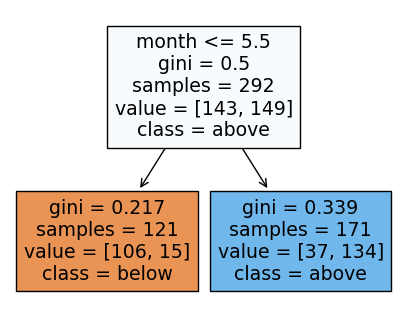

In [34]:
#
# Treeing!
#
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(5,4))              # Feel free to adjust this size...
tree_plot = tree.plot_tree(dtree_model, 
                   feature_names=FEATURES,   # Glad to have these FEATURES...
                   class_names=SPECIES,      # and these SPECIES...
                   filled=True)

In [35]:
#
# Now, we TUNE the model (with cross-validation)...
#
# We used a depth of 1    (only 1 split) 
# There's NO way to model three species with only 1 split!
#
# So, we try several depths...
# Here, the tradeoff is not so much "more accurate" 
#   + deeper always has the potential to be more accurate
#   + but at the risk of _overfitting_ the training data!
#
# Rather it's the underfitting(bias)/overfitting(variance) tradeoff
#   + A heuristic: "Choose the _smallest_ depth at which the accuracy has plateaued"
#   + that is, is close to maximum...
#

In [36]:
#
# To compare different tree-depths, we use cross validation
#

from sklearn.model_selection import cross_val_score

#
# cross-validation splits the training set into two pieces:
#   + model-building and model-validation. We'll use "build" and "validate"
#

best_d = 1
best_accuracy = 0.0

for d in range(1,10+1):
    cv_model = tree.DecisionTreeClassifier(max_depth=d)   # for each depth, d
    cv_scores = cross_val_score( cv_model, X_train, y_train, cv=5 ) # 5 means 80/20 split
    # print(cv_scores)  # we usually don't want to see the five individual scores 
    average_cv_accuracy = cv_scores.mean()  # more likely, only their average
    print(f"depth: {d:2d}  cv accuracy: {average_cv_accuracy:7.4f}")
    
    if average_cv_accuracy > best_accuracy:
        best_accuracy = average_cv_accuracy
        best_d = d

    
    
# assign best value of d to best_depth
best_depth = best_d   # may have to hand-tune this, depending on what happens...
print()
print(f"best_depth = {best_depth} with acc: {best_accuracy} is our balance.")
print()
print("Too deep and the tree will _overfit_ the training data.")
print("Too shallow and the tree will _underfit_ the training data.")

depth:  1  cv accuracy:  0.8222
depth:  2  cv accuracy:  0.8222
depth:  3  cv accuracy:  0.8393
depth:  4  cv accuracy:  0.8051
depth:  5  cv accuracy:  0.8050
depth:  6  cv accuracy:  0.7981
depth:  7  cv accuracy:  0.8220
depth:  8  cv accuracy:  0.8049
depth:  9  cv accuracy:  0.8084
depth: 10  cv accuracy:  0.8015

best_depth = 3 with acc: 0.8392752776154296 is our balance.

Too deep and the tree will _overfit_ the training data.
Too shallow and the tree will _underfit_ the training data.


In [37]:
#
# Now, we re-create and re-run the  "Model-building and -training Cell"
#
# this time, with the best depth, best_d, found by cross-validation model tuning:
#
from sklearn import tree      # for decision trees

# we should have best_depth from our cv exploration
dtree_model_tuned = tree.DecisionTreeClassifier(max_depth=best_depth)

# we train the model (it's one line!)
dtree_model_tuned.fit(X_train, y_train)                              # yay!  trained!
print("Created and trained a DT classifier with max depth =", best_depth) 

Created and trained a DT classifier with max depth = 3


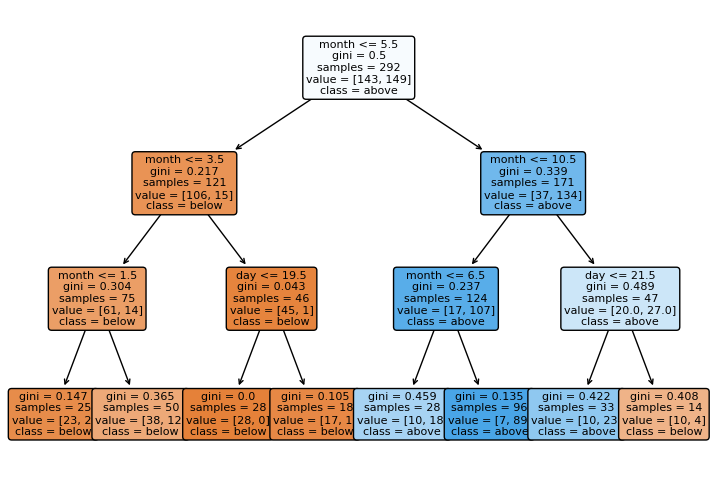

In [38]:
#
# Now, let's see the tree!
#

filename = 'tree_data.gv'    # sometimes .dot is used, instead of .gv

tree.export_graphviz(dtree_model_tuned, out_file=filename,  # the filename constructed above...!
                            feature_names=FEATURES, # actual feature names, not species
                            filled=True,              # fun!
                            rotate=False,             # False for Up/Down; True for L/R
                            class_names=SPECIES,      # good to have   
                            leaves_parallel=True )    # lots of options!

# Use this line to print the tree to the console in the dot language:
# print(f"file {filename} written. Try pasting its contents to  http://viz-js.com/")

# with open(filename, "r") as f:    # here, it will print to a file:
#     all_file_text = f.read()
#     print(all_file_text)

#
# Treeing using matplotlib:
#
fig = plt.figure(figsize=(9,6))
tree_plot = tree.plot_tree(dtree_model_tuned, 
                   feature_names=FEATURES,   # Glad to have these!
                   class_names=SPECIES,      # and these!!
                   filled=True,
                   rounded=True,
                   fontsize=8)

In [39]:
#
# Re-create and re-run the  "Model-testing Cell"     How does it do with best_k?!
#
predicted_labels = dtree_model_tuned.predict(X_test)
actual_labels = y_test

# Let's print them so we can compare...
print("Predicted labels:", predicted_labels)
print("Actual labels:", actual_labels)
print()

# and, we'll print our nicer table...
compare_labels(predicted_labels,actual_labels)

Predicted labels: [0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0.]
Actual labels: [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0.]

row   0 :        below below          
row   1 :        above below          incorrect
row   2 :        above above          
row   3 :        below below          
row   4 :        below below          
row   5 :        below below          
row   6 :        below above          incorrect
row   7 :        below above          incorrect
row   8 :        above above          
row   9 :        below below          
row  10 :        below below          
row  11 :        above above          
row  12 :        

63

In [40]:
print(dtree_model_tuned.feature_importances_)
print()

# let's see them with each feature name:
IMPs = dtree_model_tuned.feature_importances_

# enumerate is great when you want indices _and_ elements!
for i, importance in enumerate(IMPs):
    perc = importance*100
    print(f"Feature {COLUMNS[i]:>12s} has {perc:>7.2f}% of the decision-making importance.")

[0.955732 0.044268]

Feature        month has   95.57% of the decision-making importance.
Feature          day has    4.43% of the decision-making importance.


In [41]:
#
# Ok!  We have tuned our DT to use the "best" depth...
#
# Now, we use ALL available data to train our final predictive model:
#

from sklearn import tree      # for decision trees

# we should have best_depth from our cv exploration
dtree_model_final = tree.DecisionTreeClassifier(max_depth=best_depth)

# we train the model (it's one line!)
dtree_model_final.fit(X_all, y_all)                              # yay!  trained!
print("Created and trained a 'final' DT classifier with max depth =", best_depth) 

Created and trained a 'final' DT classifier with max depth = 3


In [44]:
#
# final predictive model (decision trees), with tuned parameters + ALL data incorporated
#

def predictive_model( Features, Model ):
    """ input: a list of two features, month and day 
        output: predicted births above or below median 
    """
    our_features = np.asarray([Features])                 # extra brackets needed
    predicted_species = Model.predict(our_features)       # The model's prediction!
    predicted_species = int(round(predicted_species[0]))  # unpack the extra brackets
    return predicted_species
   
#
# Try it!
# 
# Features = eval(input("Enter new Features: "))
#
Features = [6.7,3.3,5.7,0.1]  # [5.8,2.7,4.1,1.0] [4.6,3.6,3.0,2.2] [6.7,3.3,5.7,2.1]

LoD = [[10,4.2],
[1.5,1.5],
[2,-1],
[-10,0],
[0,0],
[2,32],
[9.2,6.5],
[3.14159,2.71828],
[42,42]]


# run on each one:
for Features in LoD:
    predicted_species = predictive_model( Features, dtree_model_final )  # pass in the model, too!
    name = SPECIES[predicted_species]
    print(f"I predict {name} from the features {Features}")    # Answers in the assignment...

I predict above from the features [10, 4.2]
I predict below from the features [1.5, 1.5]
I predict below from the features [2, -1]
I predict below from the features [-10, 0]
I predict below from the features [0, 0]
I predict below from the features [2, 32]
I predict above from the features [9.2, 6.5]
I predict below from the features [3.14159, 2.71828]
I predict below from the features [42, 42]


In [45]:
#
# feature importances!
# 
#     feature importances are computed by tracking which feature is used at each decision-point
#     weighted by how often that decision-point is checked 
# 
# feature importances are often even more "important" than predictions, 
#         because they invite the question, "why" (Here, not a computational, but a biological/botanical q'n)
#

print(dtree_model_final.feature_importances_)
print()

# let's see them with each feature name:
IMPs = dtree_model_final.feature_importances_

# enumerate is great when you want indices _and_ elements!
for i, importance in enumerate(IMPs):
    perc = importance*100
    print(f"Feature {COLUMNS[i]:>12s} has {perc:>7.2f}% of the decision-making importance.")

[0.95126802 0.04873198]

Feature        month has   95.13% of the decision-making importance.
Feature          day has    4.87% of the decision-making importance.


In [46]:
#
# That's it!  Welcome to the world of Decision-Tree models!    
#

#
# But wait, there's more!     More workflows, and more trees...
#

#
# Random Forests are next:

## Then: &nbsp; _Random Forests_

In [ ]:
#
# Here, use this week's iris-modeler to create, cross-validate, and model
#       bday popularity using Random Forests
#

# Be sure to cross-validate on the TWO parameters: depth and number-of-estimators
#    (the number-of-estimators is the number of trees used)

In [47]:
#
# +++ We're back at the "Model-building and Model-training Cell"
#       
# Create a RF model and train it! 
#
from sklearn import tree      # for decision trees
from sklearn import ensemble  # for random forests, an ensemble classifier

best_d = 1            # we don't know what depth to use, so we guess...
best_num_trees = 42   # again, we guess
rforest_model = ensemble.RandomForestClassifier(max_depth=best_d, 
                                                n_estimators=best_num_trees,
                                                max_samples=0.5)  
# This max_samples=0.5 is the fraction of rows to use for each DT 
# For all of our forests, we will let max_samples be 0.5   

# We'll explore best_d and best_num_trees...

# we train the model (again, one line):
rforest_model.fit(X_train, y_train)                              # yay!  trained!
print(f"Built an RF with depth={best_d} and number of trees={best_num_trees}")  

Built an RF with depth=1 and number of trees=42


In [48]:
#
# +++ This is the "Model-testing Cell"
#
# Now, let's see how well we did on our "held-out data" (the testing data)
#

# We run our test set!
predicted_labels = rforest_model.predict(X_test)
actual_labels = y_test

# Let's print them so we can compare...
print("Predicted labels:", predicted_labels)
print("Actual  labels  :", actual_labels)

# And, some overall results
num_correct = sum(predicted_labels == actual_labels)
total = len(actual_labels)
print(f"\nResults on test set:  {num_correct} correct out of {total} total.")

# and, let's print our table, too...
compare_labels(predicted_labels,actual_labels)

Predicted labels: [0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0.]
Actual  labels  : [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0.]

Results on test set:  60 correct out of 74 total.
row   0 :        below below          
row   1 :        above below          incorrect
row   2 :        above above          
row   3 :        below below          
row   4 :        below below          
row   5 :        below below          
row   6 :        above above          
row   7 :        below above          incorrect
row   8 :        above above          
row   9 :        below below          
row  10 :        above below          incorrect
row

60

One of the forest's trees is DecisionTreeClassifier(max_depth=1, max_features='sqrt',
                       random_state=1165682546)
file rf_tree_028.gv written. Try copying the result to http://viz-js.com/ 

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
graph [ranksep=equally, splines=polyline] ;
edge [fontname="helvetica"] ;
0 [label="month <= 5.5\ngini = 0.5\nsamples = 115\nvalue = [72, 74]\nclass = above", fillcolor="#fafcfe"] ;
1 [label="gini = 0.238\nsamples = 44\nvalue = [50, 8]\nclass = below", fillcolor="#e99559"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.375\nsamples = 71\nvalue = [22, 66]\nclass = above", fillcolor="#7bbeee"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
{rank=same ; 0} ;
{rank=same ; 1; 2} ;
}


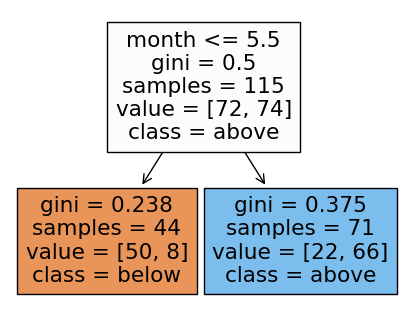

In [49]:
#
# we can get the individual trees, if we want...
#
tree_index = 28   # which tree
one_rf_tree = rforest_model.estimators_[tree_index]
print(f"One of the forest's trees is {one_rf_tree}")

# From there, it's possible to create a graphical version...
filename = f'rf_tree_{tree_index:03d}.gv'             # f strings! Could save all trees, but we won't do so here. 
tree.export_graphviz(one_rf_tree, out_file=filename,  # the filename constructed above...!
                            feature_names=FEATURES, # actual feature names, not species
                            filled=True,              # fun!
                            rotate=False,             # False for Up/Down; True for L/R
                            class_names=SPECIES,      # good to have   
                            leaves_parallel=True )    # lots of options!
                            
print(f"file {filename} written. Try copying the result to http://viz-js.com/ \n")

with open(filename, "r") as f:
    file_text = f.read()
    print(file_text)

#
# Treeing!
#
fig = plt.figure(figsize=(5,4))
tree_plot = tree.plot_tree(one_rf_tree, 
                   feature_names=FEATURES,   # Glad to have these!
                   class_names=SPECIES,      # and these!!
                   filled=True)

In [50]:
#
# Now, to TUNE the model (with cross-validation)...
#
#
# We previously used a depth of 1  and #trees of 42  
#
# So, we try several depths to find best_d
#            and several #'s of trees to find best_ntrees
#
# The tradeoff is underfitting/overfitting and time...
#     "too many trees" tends may add noticeably to execution time

In [51]:
#
# So, to compare different parameters, let's use cv
#

from sklearn.model_selection import cross_val_score

#
# cross-validation splits the training set into two pieces:
#   + model-building and model-validation. We'll use "build" and "validate"
#

#
# lab task:  wrap this loop in another one! (or create an inner one...)
#

best_d = 1         # range(1,6)
best_ntrees = 50   # [50,150,250]
best_accuracy = 0

for d in range(1,6):
    for ntrees in [50,150,250]:
        rforest_model = ensemble.RandomForestClassifier(max_depth=d, 
                                                        n_estimators=ntrees,
                                                        max_samples=0.5)
        cv_scores = cross_val_score( rforest_model, X_train, y_train, cv=5 ) # 5 means 80/20 split
        average_cv_accuracy = cv_scores.mean()  # more likely, only their average
        print(f"depth: {d:2d} ntrees: {ntrees:3d} cv accuracy: {average_cv_accuracy:7.4f}")
        if average_cv_accuracy > best_accuracy:
            best_accuracy = average_cv_accuracy
            best_d = d
            best_ntrees = ntrees

# 
# your task: assign best values by keeping a "running max"
#
best_depth = best_d   
best_num_trees = best_ntrees

# This will be incorrect when initially run (you'll fix it):
print()
print(f"best_depth: {best_depth} and best_num_trees: {best_num_trees} are our choices. Acc: {best_accuracy}")  

#
# remember that the RF lab task is to complete this nested cross-validation loop!
#

depth:  1 ntrees:  50 cv accuracy:  0.8222
depth:  1 ntrees: 150 cv accuracy:  0.8222
depth:  1 ntrees: 250 cv accuracy:  0.8222
depth:  2 ntrees:  50 cv accuracy:  0.8222
depth:  2 ntrees: 150 cv accuracy:  0.8222
depth:  2 ntrees: 250 cv accuracy:  0.8222
depth:  3 ntrees:  50 cv accuracy:  0.8188
depth:  3 ntrees: 150 cv accuracy:  0.8222
depth:  3 ntrees: 250 cv accuracy:  0.8222
depth:  4 ntrees:  50 cv accuracy:  0.8359
depth:  4 ntrees: 150 cv accuracy:  0.8290
depth:  4 ntrees: 250 cv accuracy:  0.8325
depth:  5 ntrees:  50 cv accuracy:  0.8324
depth:  5 ntrees: 150 cv accuracy:  0.8392
depth:  5 ntrees: 250 cv accuracy:  0.8392

best_depth: 5 and best_num_trees: 150 are our choices. Acc: 0.8392168322618352


In [52]:
#
# Now, we re-create and re-run the  "Model-building and -training Cell"
#
from sklearn import tree      # for decision trees
from sklearn import ensemble  # for random forests
best_depth =  best_depth
best_num_trees = best_num_trees
# we should have best_depth and best_num_trees
rforest_model_tuned = ensemble.RandomForestClassifier(max_depth=best_depth, 
                                                      n_estimators=best_num_trees,
                                                      max_samples=0.5)

# we train the model (it's one line!)
rforest_model_tuned.fit(X_train, y_train)                              # yay!  trained!
print(f"Built an RF classifier with depth={best_depth} and ntrees={best_num_trees}") 

Built an RF classifier with depth=5 and ntrees=150


In [53]:
#
# +++ This is our "Model-testing Cell"
#
# Now, let's see how well we did on our "held-out data" (the testing data)
#

# We run our test set!
predicted_labels = rforest_model_tuned.predict(X_test)
actual_labels = y_test

# Let's print them so we can compare...
print("Predicted labels:", predicted_labels)
print("Actual  labels  :", actual_labels)

# And, some overall results
num_correct = sum(predicted_labels == actual_labels)
total = len(actual_labels)
print(f"\nResults on test set:  {num_correct} correct out of {total} total.")

# and, let's print our table, too...
compare_labels(predicted_labels,actual_labels)

Predicted labels: [0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0.]
Actual  labels  : [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0.]

Results on test set:  64 correct out of 74 total.
row   0 :        below below          
row   1 :        above below          incorrect
row   2 :        above above          
row   3 :        below below          
row   4 :        below below          
row   5 :        below below          
row   6 :        above above          
row   7 :        below above          incorrect
row   8 :        above above          
row   9 :        below below          
row  10 :        below below          
row  11 :   

64

In [54]:
#
# Ok!  We have tuned our RF to use the "best" parameters
#
# Now, we use ALL available data to train our final predictive model:
#
from sklearn import tree      # for decision trees
from sklearn import ensemble  # for random forests

# we should have best_depth and best_num_trees
rforest_model_final = ensemble.RandomForestClassifier(max_depth=best_depth, 
                                                      n_estimators=best_num_trees,
                                                      max_samples=0.5)

# we train the model (it's one line!)
rforest_model_final.fit(X_all, y_all)              # yay!  trained!
print(f"Built an RF classifier with depth={best_depth} and ntrees={best_num_trees}") 

Built an RF classifier with depth=5 and ntrees=150


In [56]:
#
# final predictive model (random forests), with tuned parameters + ALL data incorporated
#

def predictive_model( Features, Model ):
    """ input: a list of four features 
                [ sepallen, sepalwid, petallen, petalwid ]
        output: the predicted species of iris, from
                  setosa (0), versicolor (1), virginica (2)
    """
    our_features = np.asarray([Features])                 # extra brackets needed
    predicted_species = Model.predict(our_features)       # The model's prediction!
    predicted_species = int(round(predicted_species[0]))  # unpack the extra brackets
    return predicted_species
   
#
# Try it!
# 
# Features = eval(input("Enter new Features: "))
#
Features = [6.7,3.3,5.7,0.1]  # [5.8,2.7,4.1,1.0] [4.6,3.6,3.0,2.2] [6.7,3.3,5.7,2.1]

LoD = [[10,4.2],
[1.5,1.5],
[2,-1],
[-10,0],
[0,0],
[2,32],
[9.2,6.5],
[3.14159,2.71828],
[42,42]]


# run on each one:
for Features in LoD:
    predicted_species = predictive_model( Features, rforest_model_final )  # pass in the model, too!
    name = SPECIES[predicted_species]
    print(f"I predict {name} from the features {Features}")    # Answers in the assignment...

I predict above from the features [10, 4.2]
I predict below from the features [1.5, 1.5]
I predict below from the features [2, -1]
I predict below from the features [-10, 0]
I predict below from the features [0, 0]
I predict below from the features [2, 32]
I predict above from the features [9.2, 6.5]
I predict below from the features [3.14159, 2.71828]
I predict above from the features [42, 42]


In [57]:
#
# feature importances are often even more "important" than predictions...
#
#    Random forests can provide a much "smoother" measure of feature importance, since
#                   they integrate over so many individual models (each tree)
#
#    That is, it's much less likely that a feature will have 0% importance, unless it never varies
#

print(rforest_model_final.feature_importances_)
print()

# let's see them with each feature name:
IMPs = rforest_model_final.feature_importances_

# enumerate is great when you want indices _and_ elements!
for i, importance in enumerate(IMPs):
    perc = importance*100
    print(f"Feature {COLUMNS[i]:>12s} has {perc:>7.2f}% of the decision-making importance.")

[0.7733879 0.2266121]

Feature        month has   77.34% of the decision-making importance.
Feature          day has   22.66% of the decision-making importance.


In [58]:
#
# That's the random-forest model! 
#
# Let's consider the forest found, not lost, amid all of its many trees!
#

In [60]:
# we can only plot 2 dimensions at a time! 

VERTICAL = np.arange(1,12) # array of vertical input values
HORIZONT = np.arange(1,31) # array of horizontal input values
PLANE = np.zeros( (len(HORIZONT),len(VERTICAL)) ) # the output array
MODEL = rforest_model_final

col = 0
row = 0
for month in VERTICAL: # for every sepal length
  for date in HORIZONT: # for every sepal width
    Features = [month, date]
    output = predictive_model(Features,MODEL)
    #print(f"Input {Features} Output: {output}")
    PLANE[row,col] = output
    row += 1
  row = 0
  col += 1
  print(".", end="")  # so we know it's running
  if col % 42 == 0: print() # same...

print("\n", PLANE[0:3,0:3]) # small bit of the upper-left corner

...........
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Remember our species-to-number mapping:
0 - below median births 
1 - above median births


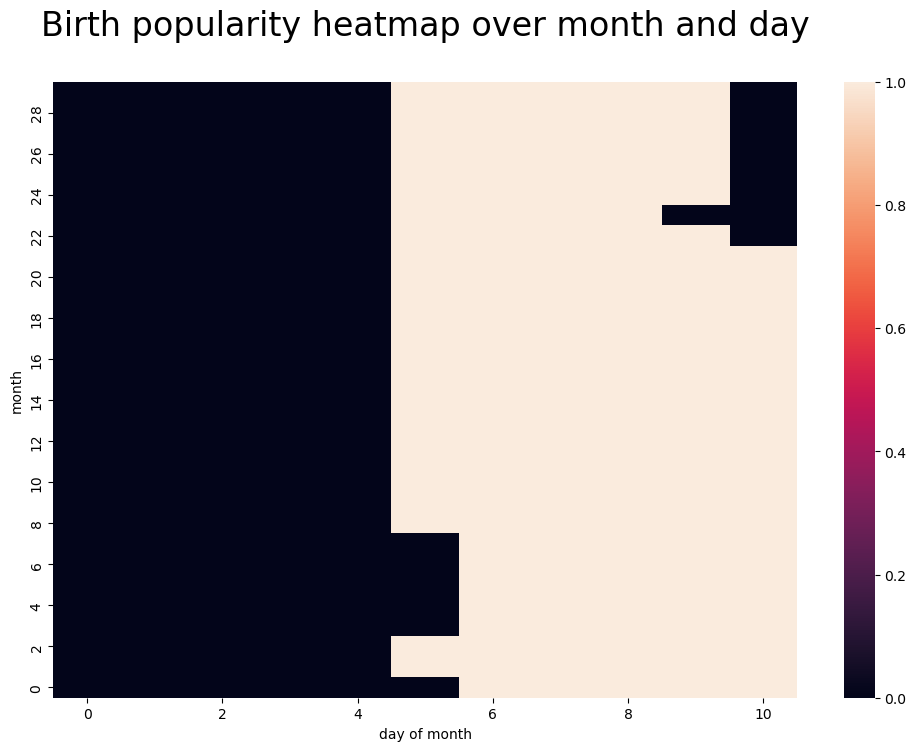

In [64]:
import seaborn as sns
# sns.heatmap(PLANE)

#sns.set(rc = {'figure.figsize':(18,12)})  # figure size!

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(PLANE)
ax.set_title(f"Birth popularity heatmap over month and day\n", fontsize=24)
ax.invert_yaxis() # to match our usual direction
ax.set(xlabel="day of month", ylabel="month")
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])


print("Remember our species-to-number mapping:")
print("0 - below median births ")
print("1 - above median births")

<br>
<hr>
<br>

### Final, big-picture question:  
+ What are the relative "feature importances" of the two features
  + month
  + day
+ ... at least, in terms of "birthday popularity," as we've defined it?

Reflect, in a sentence or two, on the values of feature importances that you found.
+ To use Erica Thompson's framing, 
+ how much trust (or weight) would you attribute to this model and its feature importances, "outside of Model Land"? 

In [ ]:
#
# Your thoughts... / why...
#

Month seems to have much greater importance than day, both in the decision tree and random forest approaches. This appears visually in the heatmap above, as you can see there is a clear cutoff around month 5 (may) where nearly all days before that month have below median predicted births, and most days after that month have above median predicted births. There are no such clear trends in days, although there are a few below-average outliers in the late months for days that are later in the month. In that case, the day reverses the month-based trend, and captures the decrease in births seen around Christmas. 

I wouldn't trust the model and its feature importances that greatly 'outside of Model Land' because many of the trends leading to changes in birth popularity are better explained with knowledge of greater context (weather, holidays, tax system, etc.) rather than solely through the data itself using decision trees, random forests or regression. 

In [66]:
#
# Welcome to the world of model-building workflows!!    
#

#
# In fact, the next task on this hw is to run at least one more ML workflow:   
#          (2) Digits, (ec) Your-own-data, ...
#